In [26]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import DataProcessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input, Dropout,Attention, Activation, Flatten, TimeDistributed, RepeatVector, Permute, Multiply, Lambda,Bidirectional
from keras import backend as K

dataProcess = DataProcessing.ETL()
df = dataProcess.Load_Clean_Data('./historical_data/Binance_ETHUSDT_d.csv','1d')

cols= ['ti_stoch_kd','ti_MACD']
cols_to_normalize = ['open','high', 'low', 'close', 'base_volume'] # removed num_trades
df = dataProcess.Add_TI_Data(df, cols=cols)
df= dataProcess.Add_Label(df,cols_to_normalize=cols_to_normalize)
#important: reverse the order and Reset the index to start from 0
df= df[::-1]
df.reset_index(drop=True, inplace=True)


#removed time ('unix_start_datetime')
x_cols = cols_to_normalize+cols
labels = ['result_A','result_B']
tensor_temp= df[x_cols+labels]
sequence_num=14 # also called timesteps
tensor = dataProcess.create_tensor_with_sequence(tensor_temp,labels,sequence_num)
#note we have 2 labels, one for daily(B) another for shortterm (A) => shorterm>daily
#y1= df['result_A']
X= tensor.loc[:,~tensor.columns.isin(labels)]


y2= tensor['result_B']
y = y2.replace({'up': 1, 'down': -1, 'flat':0})
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=3)
print(y)
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# print the shape of each set
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)
print("Training data shape:", y_train.shape)
print("Validation data shape:", y_val.shape)
print("Test data shape:", y_test.shape)

created
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
Training data shape: (1282, 105)
Validation data shape: (321, 105)
Test data shape: (401, 105)
Training data shape: (1282, 3)
Validation data shape: (321, 3)
Test data shape: (401, 3)


In [27]:
# Important: reshape it into a 3D tensor with dimensions (number of samples, sequence length, number of features) to process with LSTM
X_train = X_train.to_numpy().reshape(X_train.shape[0],sequence_num+1,len(x_cols))
X_test = X_test.to_numpy().reshape(X_test.shape[0],sequence_num+1,len(x_cols))
X_val = X_val.to_numpy().reshape(X_val.shape[0],sequence_num+1,len(x_cols))

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (1282, 15, 7)
Validation data shape: (321, 15, 7)
Test data shape: (401, 15, 7)


In [50]:
y_train[0]

array([1., 0., 0.], dtype=float32)

In [84]:
from keras_self_attention import SeqSelfAttention
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
model = Sequential([
Bidirectional(LSTM(units=84, return_sequences=True, input_shape=(sequence_num+1,len(x_cols)))),
Dropout(0.4),
Bidirectional(LSTM(units=64, return_sequences=True)),
Dropout(0.6),
Bidirectional(
    LSTM(
    units=32,
    return_sequences=True)),
# Dropout(0.7),
Dropout(0.7),
SeqSelfAttention(attention_activation='tanh'),
Flatten(),
Dense(3,activation='softmax')])



from sklearn.metrics import precision_score, recall_score, f1_score

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       ])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 30)


Epoch 1/40
41/41 [==============================] - 8s 53ms/step - loss: 0.9650 - accuracy: 0.4984 - precision_3: 0.4982 - recall_3: 0.2122 - auc: 0.7093 - tp: 272.0000 - fp: 274.0000 - tn: 2290.0000 - fn: 1010.0000 - val_loss: 0.9093 - val_accuracy: 0.4798 - val_precision_3: 0.4911 - val_recall_3: 0.4299 - val_auc: 0.7246 - val_tp: 138.0000 - val_fp: 143.0000 - val_tn: 499.0000 - val_fn: 183.0000
Epoch 2/40
41/41 [==============================] - 1s 25ms/step - loss: 0.9181 - accuracy: 0.5226 - precision_3: 0.5529 - recall_3: 0.3424 - auc: 0.7332 - tp: 439.0000 - fp: 355.0000 - tn: 2209.0000 - fn: 843.0000 - val_loss: 0.8943 - val_accuracy: 0.5389 - val_precision_3: 0.5438 - val_recall_3: 0.4642 - val_auc: 0.7438 - val_tp: 149.0000 - val_fp: 125.0000 - val_tn: 517.0000 - val_fn: 172.0000
Epoch 3/40
41/41 [==============================] - 1s 25ms/step - loss: 0.9129 - accuracy: 0.5335 - precision_3: 0.5471 - recall_3: 0.3081 - auc: 0.7360 - tp: 395.0000 - fp: 327.0000 - tn: 2237.0000

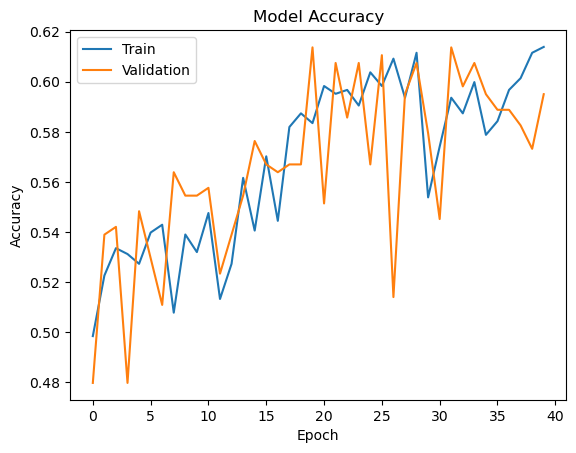

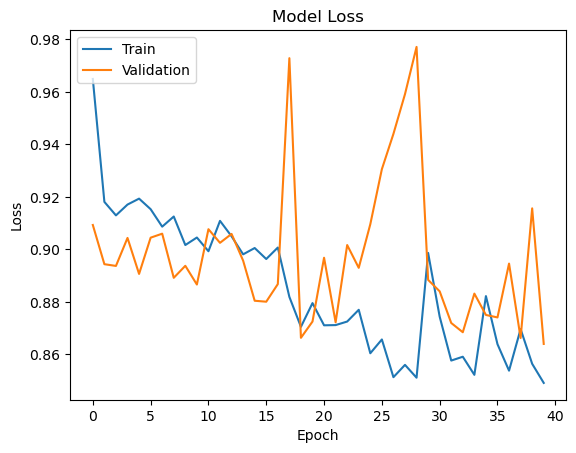

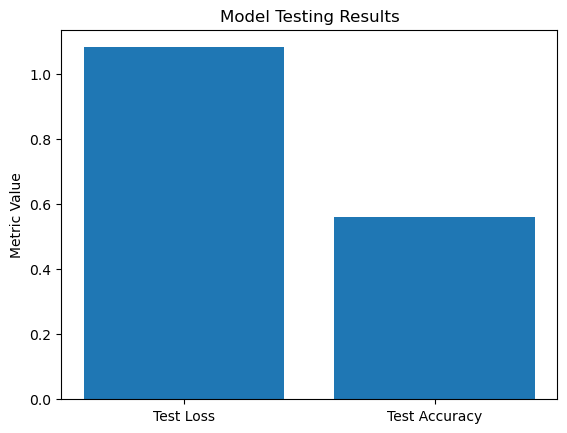

In [85]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate model on test data

# Plot testing accuracy and loss
plt.bar(['Test Loss', 'Test Accuracy'], [loss, accuracy])
plt.title('Model Testing Results')
plt.ylabel('Metric Value')
plt.show()

In [74]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_131 (Bidirect  (None, 15, 168)          61824     
 ional)                                                          
                                                                 
 dropout_121 (Dropout)       (None, 15, 168)           0         
                                                                 
 bidirectional_132 (Bidirect  (None, 15, 128)          119296    
 ional)                                                          
                                                                 
 dropout_122 (Dropout)       (None, 15, 128)           0         
                                                                 
 bidirectional_133 (Bidirect  (None, 15, 64)           41216     
 ional)                                                          
                                                     

In [ ]:
#code to use softmax as the last layer for classifying up down flat along with the probability

import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

# Create a simple neural network model
model = Sequential()
model.add(Dense(3, input_dim=4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Generate some input data
X = np.array([[1, 2, 3, 4]])

# Get the predicted probabilities for each class
y_pred = model.predict(X)

# Get the predicted class label and associated probability
predicted_class_label = np.argmax(y_pred)
predicted_probability = y_pred[0][predicted_class_label]

# Print the results
print('Predicted class label:', predicted_class_label)
print('Associated probability:', predicted_probability)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       ])

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return K.mean(f1)

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(),
                       f1])






created


/Users/pratyushpradhan/Developer/Personal/Projects/Crypto/CryptoDataProcessingAndML/Version2/DataProcessing.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  MACD = ta.macd(df['close'])


[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
Epoch 1/24
41/41 [==============================] - 7s 46ms/step - loss: 0.9674 - accuracy: 0.4899 - val_loss: 0.8788 - val_accuracy: 0.5607
Epoch 2/24
41/41 [==============================] - 1s 23ms/step - loss: 0.9418 - accuracy: 0.5062 - val_loss: 0.8922 - val_accuracy: 0.4984
Epoch 3/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9231 - accuracy: 0.5094 - val_loss: 0.9048 - val_accuracy: 0.5109
Epoch 4/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9237 - accuracy: 0.5265 - val_loss: 0.8931 - val_accuracy: 0.5483
Epoch 5/24
41/41 [==============================] - 1s 23ms/step - loss: 0.9246 - accuracy: 0.5164 - val_loss: 0.8862 - val_accuracy: 0.5607
Epoch 6/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9231 - accuracy: 0.5296 - val_loss: 0.8952 - val_accuracy: 0.5576
Epoch 7/24
41/41 [==============================] - 1s 22ms/step - loss: 0.9

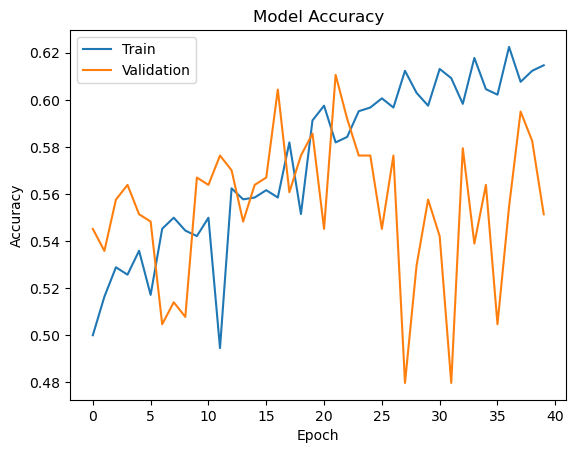

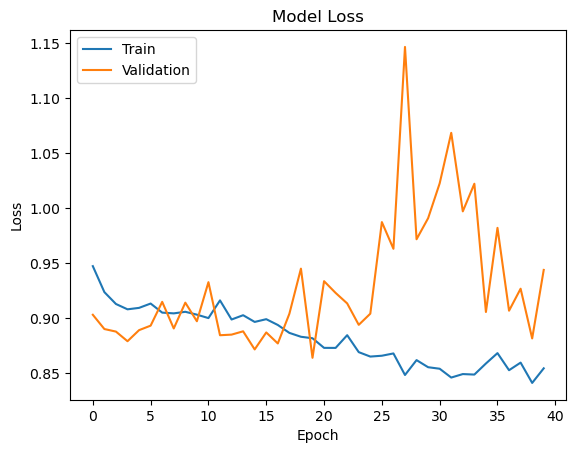

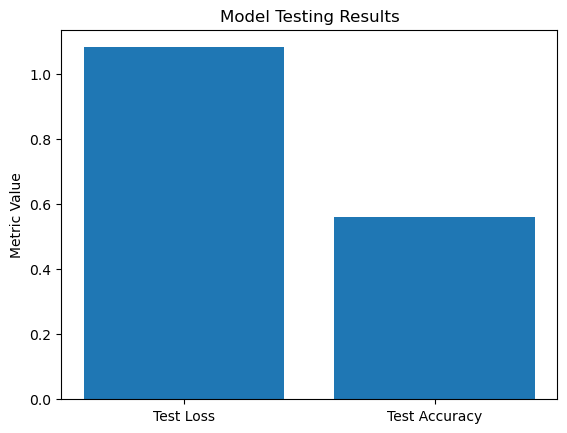

In [83]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate model on test data

# Plot testing accuracy and loss
plt.bar(['Test Loss', 'Test Accuracy'], [loss, accuracy])
plt.title('Model Testing Results')
plt.ylabel('Metric Value')
plt.show()

In [ ]:
model.summary()